# Compute the OVL & SMD

Include:
1. whole population of every database vs the normal range
2. between databases (dropped in the end)
3. best vs worst of every database

Update 2021.01.20

Update the names of databases:
1. e-ICU -> eICU-RCD
2. PLAGH -> PLAGH-ICU db
3. HJ23 -> UCIHJ23 db
4. AUMC -> AUMCdb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde
from scipy import integrate
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
import scipy.stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

# Load data

In [2]:
data_mimic = pd.read_csv('../datasets/processed data/MIMIC-data.csv')
data_aumc = pd.read_csv('../datasets/processed data/AUMC-data.csv')
data_eicu = pd.read_csv('../datasets/processed data/eCRD-data.csv')
data_plagh = pd.read_csv('../datasets/processed data/PLAGH-data.csv')
data_HJ23 = pd.read_csv('../datasets/processed data/HJ23-data.csv')

In [3]:
#remove outliers
#define the obvious outlier ranges
lab_outlier_ranges = {'CREATININE': [0,30],
                      'HEMOGLOBIN': [0.1,30],
                      'LACTATE': [0,30],
                      'SODIUM': [50,300]
                     }


kinds=['_min','_max']
for kind in kinds:
    for l, u in iter(sorted(lab_outlier_ranges.items())):
        if (l.lower()+kind) not in data_plagh.columns.values:
            data_plagh[l.lower()+kind]=np.nan
        if (l.lower()+kind) not in data_eicu.columns.values:
            data_eicu[l.lower()+kind]=np.nan
        
        data_mimic.loc[data_mimic[(data_mimic[l.lower()+kind]<lab_outlier_ranges[l][0])|(data_mimic[l.lower()+kind]>lab_outlier_ranges[l][1])].index,
                       [l.lower()+kind]]=np.nan
        
        data_eicu.loc[data_eicu[(data_eicu[l.lower()+kind]<lab_outlier_ranges[l][0])|(data_eicu[l.lower()+kind]>lab_outlier_ranges[l][1])].index,
                       [l.lower()+kind]]=np.nan
        
        data_plagh.loc[data_plagh[(data_plagh[l.lower()+kind]<lab_outlier_ranges[l][0])|(data_plagh[l.lower()+kind]>lab_outlier_ranges[l][1])].index,
                       [l.lower()+kind]]=np.nan
        
        data_aumc.loc[data_aumc[(data_aumc[l.lower()+kind]<lab_outlier_ranges[l][0])|(data_aumc[l.lower()+kind]>lab_outlier_ranges[l][1])].index,
                       [l.lower()+kind]]=np.nan
        
        data_HJ23.loc[data_HJ23[(data_HJ23[l.lower()+kind]<lab_outlier_ranges[l][0])|(data_HJ23[l.lower()+kind]>lab_outlier_ranges[l][1])].index,
                       [l.lower()+kind]]=np.nan

In [4]:
data_plagh['lactate_max']=np.nan

In [5]:
lab_ranges_us = {'CREATININE': [0.4,1.1],
                 'HEMOGLOBIN': [11.2,15.7],
                 'LACTATE': [0.5,2.0],
                 'SODIUM': [133,145],
                }

lab_ranges_cn = {'CREATININE': [0.34,1.24],
                 'HEMOGLOBIN': [12.8,16.7],
                 'LACTATE': [0.7,2.1],
                 'SODIUM': [130,150],
                }

lab_ranges_netherlands = {'CREATININE': [0.8,1.16],
                          'HEMOGLOBIN': [12.9,16.5],
                          'LACTATE': [0.4,2.0],
                          'SODIUM': [135,145],
                         }

lab_ranges_hj23 = {'CREATININE': [0.7,1.3],
                   'HEMOGLOBIN': [13.0,17.0],
                   'LACTATE': [0.55,2.22],
                   'SODIUM': [132,146],
                   }

In [6]:
ovl_best_df=pd.DataFrame()
ovl_worst_df=pd.DataFrame()
smd_best_df=pd.DataFrame()
smd_worst_df=pd.DataFrame()

In [7]:
database_names=['MIMIC','eICU-RCD','PLAGH-ICU db','AUMCdb','UCIHJ23 db']
lab_names=['creatinine_max','hemoglobin_min','lactate_max','sodium_max']

# define functions

OVL is special, the lower and upper value integrate should be determined by the lab test

In [8]:
def cohen_d(x, y):
    """
    Return SMD between two distributions
    """
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(
        ((nx - 1) * np.std(x, ddof=1)**2 +
         (ny - 1) * np.std(y, ddof=1)**2) / dof)

In [9]:
#return a normal distribution with 'val1' and 'val2'quantile(2.5% and 95%)
def ResumeNorm(val1, val2):
    norm_dist = scipy.stats.norm
    norm_val1 = norm_dist.ppf(0.025)
    norm_val2 = norm_dist.ppf(0.975)
    a = (val1 - val2) / (norm_val1 - norm_val2)
    b = val1 - a * norm_val1
    return scipy.stats.norm(b, a)

In [10]:
def get_OVL(dist1, dist2, lower, upper):
#     """
#         Overlapping coefficient: integration of min value of two distribution over R. 
#         To increase compute rate, use [0,1000] instead R
#     """
    func = lambda x: min(dist1.pdf(x), dist2.pdf(x))
    return integrate.quad(func, lower, upper)

In [18]:
#comparation between databases, plot figure
def plot_betweendatabase(labname,group,lower,upper,bw):
    if group == 'all':
        df_mimic=data_mimic.copy()
        df_eicu=data_eicu.copy()
        df_plagh=data_plagh.copy()
        df_aumc=data_aumc.copy()
        df_HJ23=data_HJ23.copy()
        f_title=labname+' of all patients'
    elif group=='bestoutcome':
        df_mimic=data_mimic.loc[data_mimic['outcome_group']==1,:]
        df_eicu=data_eicu.loc[data_eicu['outcome_group']==1,:]
        df_plagh=data_plagh.loc[data_plagh['outcome_group']==1,:]
        df_aumc=data_aumc.loc[data_aumc['outcome_group']==1,:]
        df_HJ23=data_HJ23.loc[data_HJ23['outcome_group']==1,:]
        f_title=labname+' of best outcome patients'
    else:
        df_mimic=data_mimic.loc[data_mimic['icu_expire_flag']==group,:]
        df_eicu=data_eicu.loc[data_eicu['icu_expire_flag']==group,:]
        df_plagh=data_plagh.loc[data_plagh['icu_expire_flag']==group,:]
        df_aumc=data_aumc.loc[data_aumc['icu_expire_flag']==group,:]
        df_HJ23=data_HJ23.loc[data_HJ23['icu_expire_flag']==group,:]  
        if group == 0:
            f_title=labname+' of survival patients'
        else:
            f_title=labname+' of expired patients'   
            
            
    # count patients
    n_mimic = df_mimic[labname].dropna().count()
    n_eicu = df_eicu[labname].dropna().count()
    n_plagh = df_plagh[labname].dropna().count()
    n_aumc=df_aumc[labname].dropna().count()
    n_HJ23=df_HJ23[labname].dropna().count()
    print(f_title)
    print(n_mimic,n_eicu,n_plagh,n_aumc,n_HJ23)
    
    range_name=labname.split('_')[0].upper()
    
    ## Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist_us = ResumeNorm(lab_ranges_us[range_name][0], lab_ranges_us[range_name][1])
    range_dist_cn = ResumeNorm(lab_ranges_cn[range_name][0], lab_ranges_cn[range_name][1])
    range_dist_netherlands = ResumeNorm(lab_ranges_netherlands[range_name][0], lab_ranges_netherlands[range_name][1])
    range_dist_hj23 = ResumeNorm(lab_ranges_hj23[range_name][0], lab_ranges_hj23[range_name][1])
    norm_sample_mimic = range_dist_us.rvs(size=n_mimic, random_state=0)
    norm_sample_eicu = range_dist_us.rvs(size=n_eicu, random_state=0)
    norm_sample_aumc = range_dist_netherlands.rvs(size=n_aumc, random_state=0)
    norm_sample_HJ23 = range_dist_hj23.rvs(size=n_HJ23, random_state=0)
    
    # SMD
    smd_mimic = '%.2f'%cohen_d(df_mimic[labname].dropna(), norm_sample_mimic)
    smd_eicu = '%.2f'%cohen_d(df_eicu[labname].dropna(), norm_sample_eicu)
    smd_aumc = '%.2f'%cohen_d(df_aumc[labname].dropna(), norm_sample_aumc)
    smd_HJ23 = '%.2f'%cohen_d(df_HJ23[labname].dropna(), norm_sample_HJ23)
    
    
    # Test case on pandas kde: gaussian kde 
    data_kde_mimic = gaussian_kde(df_mimic[labname].dropna())
    data_kde_eicu = gaussian_kde(df_eicu[labname].dropna())
    data_kde_aumc = gaussian_kde(df_aumc[labname].dropna())
    data_kde_HJ23 = gaussian_kde(df_HJ23[labname].dropna())
    
    
    #OVL
    ovl_mimic =  '%.2f'%max(get_OVL(data_kde_mimic, range_dist_us,lower,upper))
    ovl_eicu = '%.2f'%max(get_OVL(data_kde_eicu, range_dist_us,lower,upper))
    ovl_aumc = '%.2f'%max(get_OVL(data_kde_aumc, range_dist_netherlands,lower,upper))
    ovl_HJ23 = '%.2f'%max(get_OVL(data_kde_HJ23, range_dist_hj23,lower,upper))
    

    

    
    if labname == 'lactate_max':
        ovl_plagh=np.nan
        smd_plagh=np.nan
        #use mimic lactate fill in the nan, avoid error!
        data_kde_plagh=data_kde_mimic
    else:
        norm_sample_plagh = range_dist_cn.rvs(size=n_plagh, random_state=0)
        smd_plagh ='%.2f'%cohen_d(df_plagh[labname].dropna(), norm_sample_plagh)
        data_kde_plagh = gaussian_kde(df_plagh[labname].dropna())
        ovl_plagh = '%.2f'%max(get_OVL(data_kde_plagh, range_dist_cn,lower,upper))

    dic_name=dict({'MIMIC':[df_mimic,data_kde_mimic],
                   'eICU-RCD':[df_eicu,data_kde_eicu],
                   'PLAGH-ICU db':[df_plagh,data_kde_plagh],
                   'AUMCdb':[df_aumc,data_kde_aumc],
                   'UCIHJ23 db':[df_HJ23,data_kde_HJ23] })        
        

    fig=plt.figure(figsize=(15,8))
    sns.kdeplot(df_mimic[labname].dropna(),color='r',bw=bw,
                label='MIMIC, OVL={}, SMD={}'.format(ovl_mimic,smd_mimic ))
    sns.kdeplot(df_eicu[labname].dropna(),color='b',bw=bw,
                label='eICU-RCD, OVL={}, SMD={}'.format(ovl_eicu,smd_eicu))
    sns.kdeplot(df_plagh[labname].dropna(),color='m',bw=bw,
                label='PLAGH-ICU db, OVL={}, SMD={}'.format(ovl_plagh,smd_plagh))
    sns.kdeplot(df_aumc[labname].dropna(),color='c',bw=bw,
                label='AUMCdb, OVL={}, SMD={}'.format(ovl_aumc,smd_aumc))
    sns.kdeplot(df_HJ23[labname].dropna(),color='y',bw=bw,
                label='UCIHJ23 db, OVL={}, SMD={}'.format(ovl_HJ23,smd_HJ23))
    
    plt.axvline(lab_ranges_us[range_name][0],color='r',linestyle='--', label='MIMIC&eICU-RCD normal range({} - {})'.format(lab_ranges_us[range_name][0], lab_ranges_us[range_name][1]))
    plt.axvline(lab_ranges_us[range_name][1],color='r',linestyle='--')
    
    plt.axvline(lab_ranges_cn[range_name][0],color='m',linestyle='--', label='PLAGH-ICU db normal range({} - {})'.format(lab_ranges_cn[range_name][0], lab_ranges_cn[range_name][1]))
    plt.axvline(lab_ranges_cn[range_name][1],color='m',linestyle='--')
    
    plt.axvline(lab_ranges_netherlands[range_name][0],color='c',linestyle='--', label='AUMCdb normal range({} - {})'.format(lab_ranges_netherlands[range_name][0], lab_ranges_netherlands[range_name][1]))
    plt.axvline(lab_ranges_netherlands[range_name][1],color='c',linestyle='--')
    
    plt.axvline(lab_ranges_hj23[range_name][0],color='y',linestyle='--', label='UCIHJ23 db normal range({} - {})'.format(lab_ranges_hj23[range_name][0], lab_ranges_hj23[range_name][1]))
    plt.axvline(lab_ranges_hj23[range_name][1],color='y',linestyle='--')
    
    
    plt.ylabel("Density", fontsize=16)
    #plt.title(f_title,fontsize=22)
    plt.legend(fontsize=14)
    
    
    if group=='bestoutcome':
        for database1 in database_names:
            for database2 in database_names:
                if database1 != database2:
                    ovl='%.2f'%max(get_OVL(dic_name[database1][1], dic_name[database2][1],lower,upper))
                    ovl_best_df.loc[database1 + '_vs_' + database2,range_name]=ovl
#                     resample_lista=dic_name[database1][1].resample(size=10000,seed=0)
#                     resample_listb=dic_name[database2][1].resample(size=10000,seed=0)
                    smd='%.2f'%cohen_d(dic_name[database1][0][labname].dropna(), dic_name[database2][0][labname].dropna())
                    smd_best_df.loc[database1 + '_vs_' + database2,range_name]=smd
                    
    if group==1:
        for database1 in database_names:
            for database2 in database_names:
                if database1 != database2:
                    ovl='%.2f'%max(get_OVL(dic_name[database1][1], dic_name[database2][1],lower,upper))
                    ovl_worst_df.loc[database1 + '_vs_' + database2,range_name]=ovl
#                     resample_lista=dic_name[database1][1].resample(size=10000,seed=0)
#                     resample_listb=dic_name[database2][1].resample(size=10000,seed=0)
                    smd='%.2f'%cohen_d(dic_name[database1][0][labname].dropna(), dic_name[database2][0][labname].dropna())
                    smd_worst_df.loc[database1 + '_vs_' + database2,range_name]=smd
#    plt.savefig('../figures/comparation between databases/{}/{}.png'.format(labname,f_title), dpi=300)

## sodium_max

sodium_max of all patients
37336 128745 59320 19789 4189
sodium_max of best outcome patients
8402 30158 13727 4811 891
sodium_max of survival patients
34566 121313 55939 17892 3584
sodium_max of expired patients
2770 7421 3381 1897 605


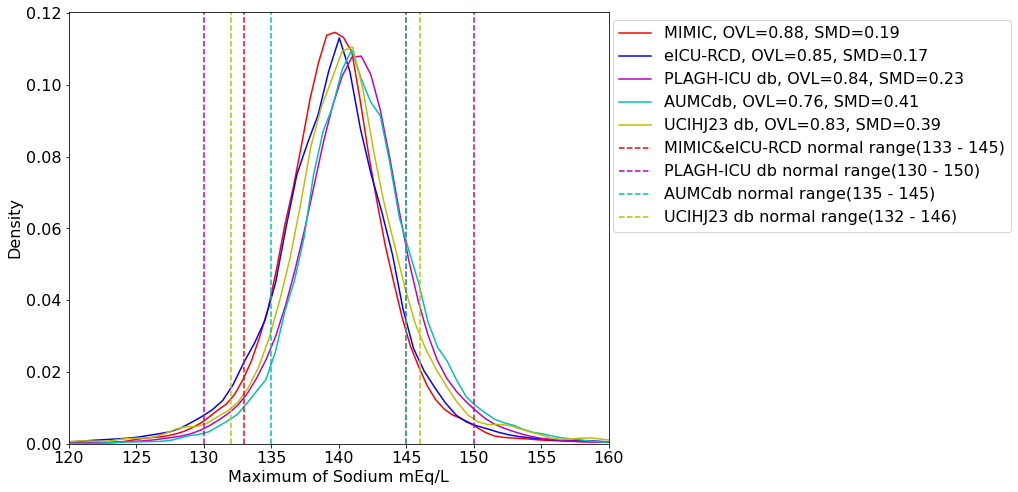

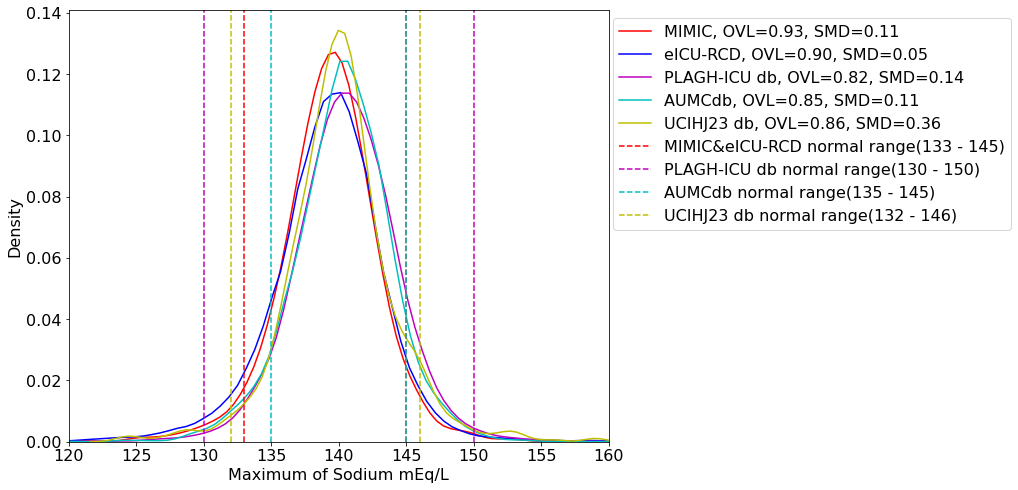

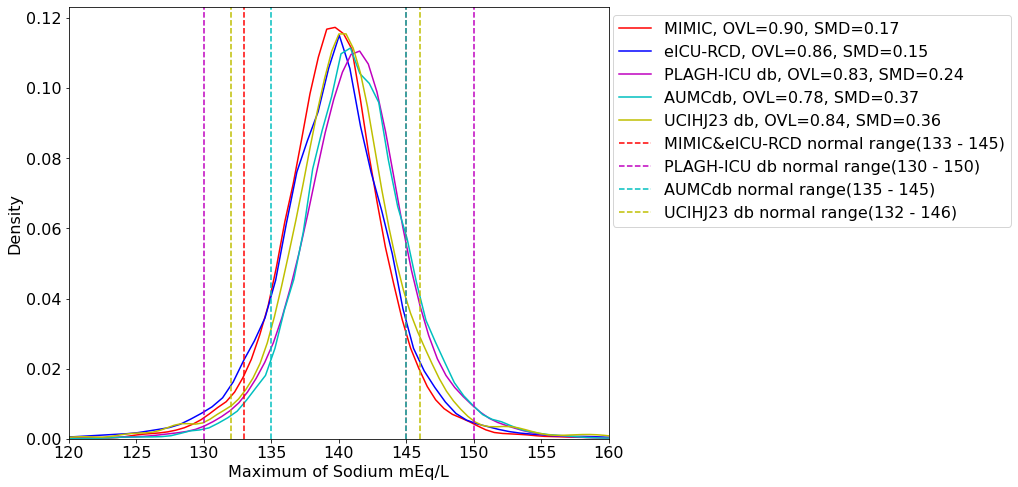

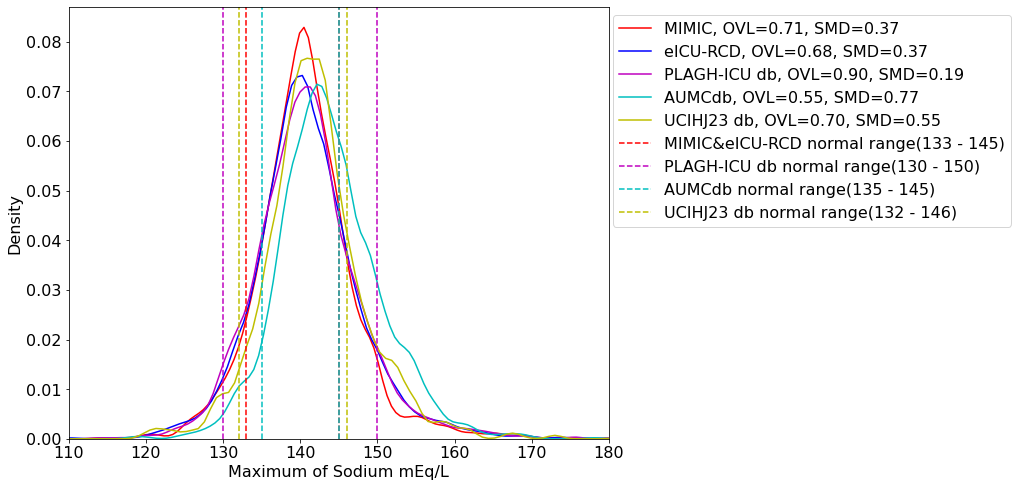

In [23]:
plot_betweendatabase('sodium_max','all',100,180,0.8)
plt.xlim(120,160)
plt.legend(bbox_to_anchor=(1.76, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Sodium mEq/L',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('sodium_max','sodium_max of all patients'), dpi=300)

plot_betweendatabase('sodium_max','bestoutcome',100,180,0.8)
plt.xlim(120,160)
plt.legend(bbox_to_anchor=(1.76, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Sodium mEq/L',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('sodium_max','sodium_max of best outcome patients'), dpi=300)

plot_betweendatabase('sodium_max',0,100,180,0.8)
plt.xlim(120,160)
plt.legend(bbox_to_anchor=(1.76, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Sodium mEq/L',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('sodium_max','sodium_max of survival patients'), dpi=300)


plot_betweendatabase('sodium_max',1,100,180,1)
plt.xlim(110,180)
plt.legend(bbox_to_anchor=(1.76, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Sodium mEq/L',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('sodium_max','sodium_max of expired patients'), dpi=300)

## creatinine_max

creatinine_max of all patients
37288 128779 59011 19496 4140
creatinine_max of best outcome patients
8393 30163 13635 4668 874
creatinine_max of survival patients
34546 121367 55628 17653 3547
creatinine_max of expired patients
2742 7401 3383 1843 593


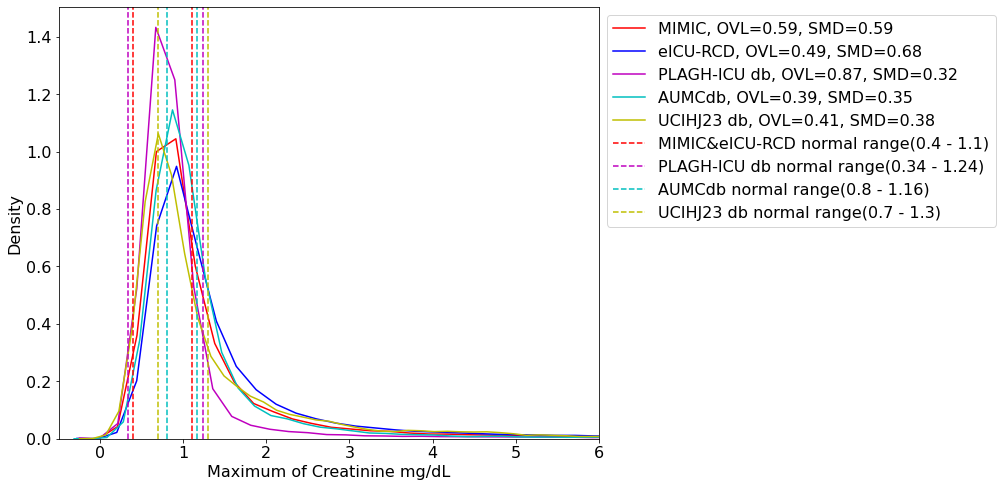

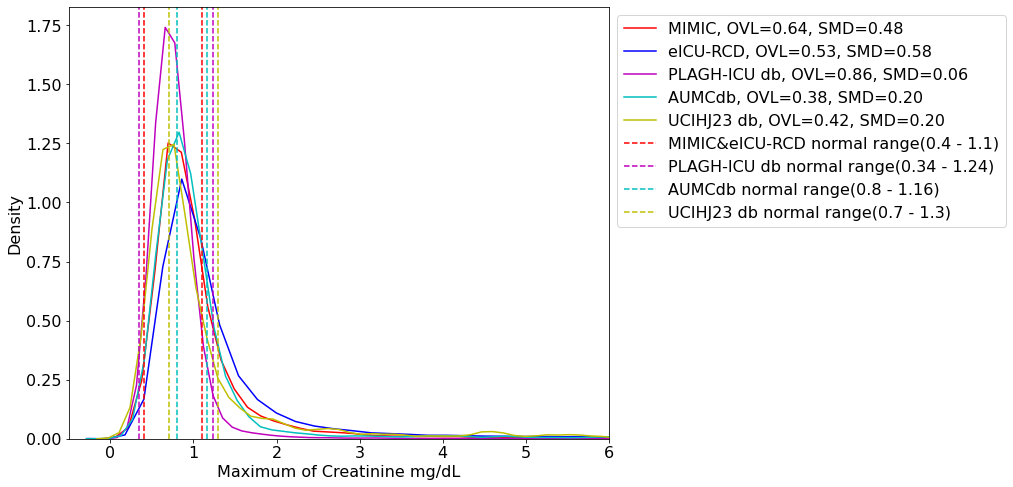

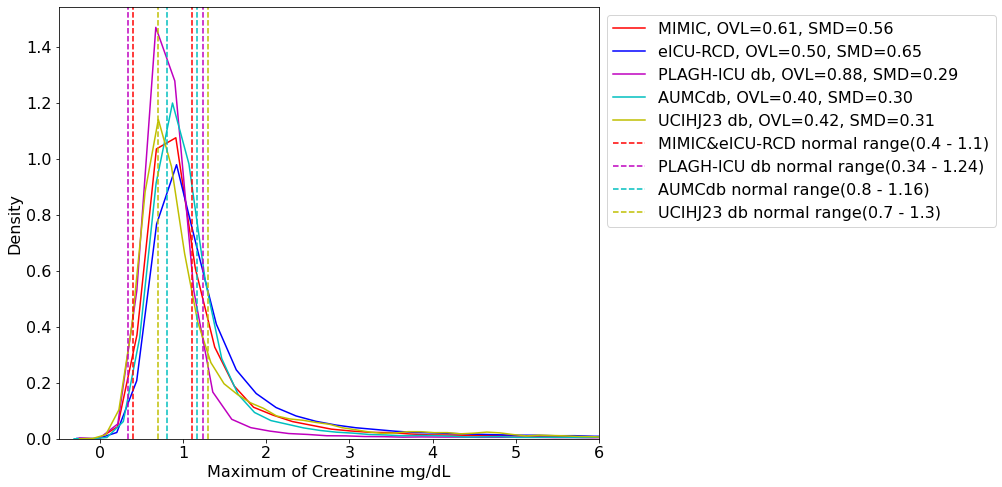

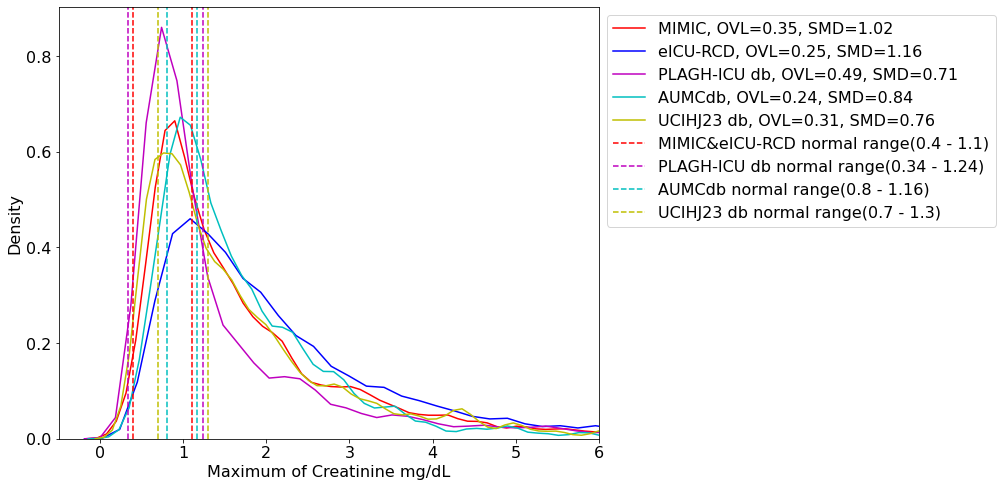

In [26]:
plot_betweendatabase('creatinine_max','all',0,np.inf,0.12)
plt.xlim(-0.5,6)
plt.legend(bbox_to_anchor=(1.75, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Creatinine mg/dL',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('creatinine_max','creatinine_max of all patients'), dpi=300)


plot_betweendatabase('creatinine_max','bestoutcome',0,np.inf,0.12)
plt.xlim(-0.5,6)
plt.legend(bbox_to_anchor=(1.75, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Creatinine mg/dL',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('creatinine_max','creatinine_max of best outcome patients'), dpi=300)


plot_betweendatabase('creatinine_max',0,-3,np.inf,0.12)
plt.xlim(-0.5,6)
plt.legend(bbox_to_anchor=(1.75, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Creatinine mg/dL',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('creatinine_max','creatinine_max of survival patients'), dpi=300)


plot_betweendatabase('creatinine_max',1,-3,np.inf,0.12)
plt.xlim(-0.5,6)
plt.legend(bbox_to_anchor=(1.75, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Creatinine mg/dL',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('creatinine_max','creatinine_max of expired patients'), dpi=300)

## hemoglobin_min

hemoglobin_min of all patients
36956 128136 58250 19715 4148
hemoglobin_min of best outcome patients
8310 29968 13514 4799 879
hemoglobin_min of survival patients
34224 120748 54984 17826 3550
hemoglobin_min of expired patients
2732 7377 3266 1889 598


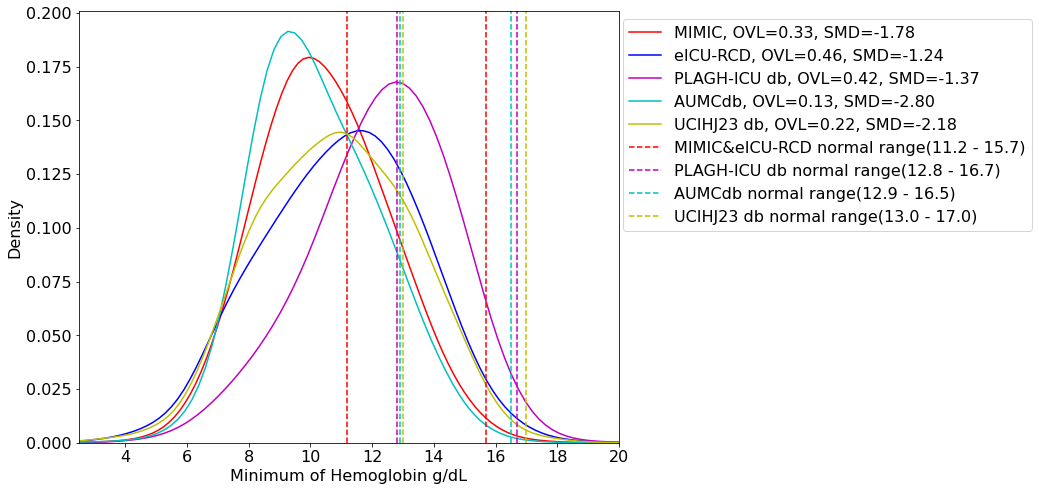

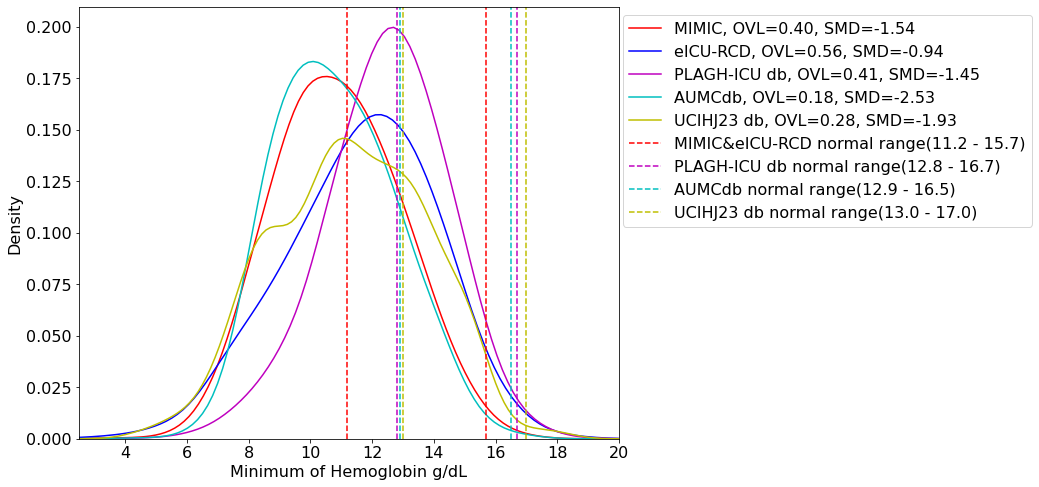

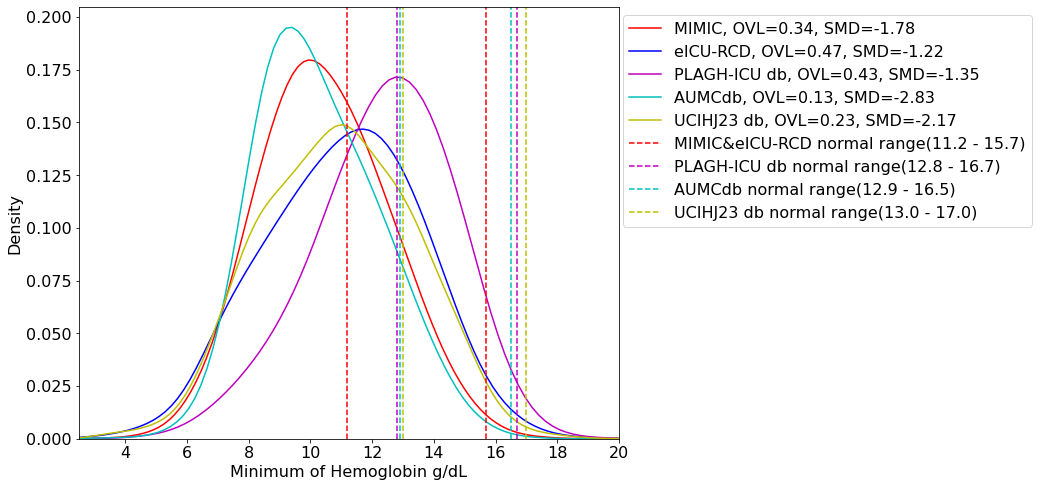

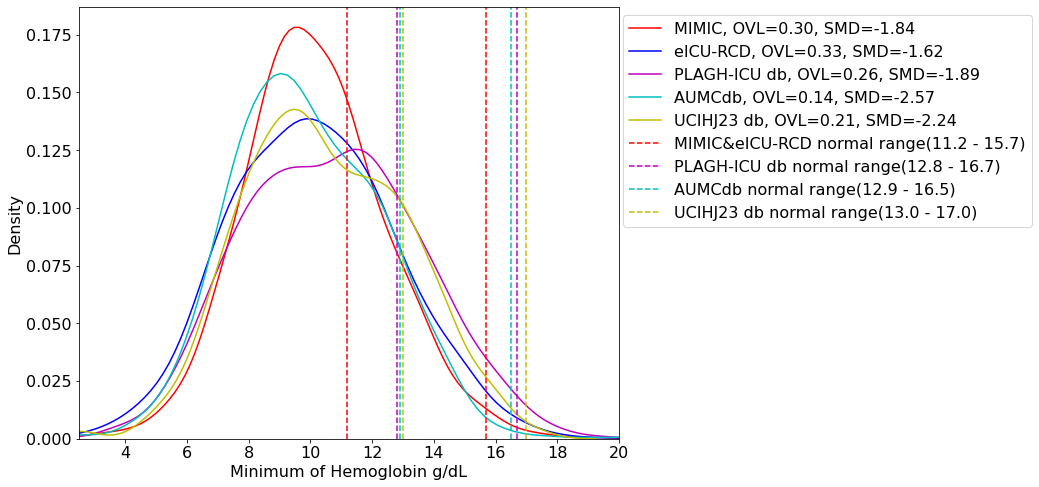

In [30]:
plot_betweendatabase('hemoglobin_min','all',2.5,np.inf,0.6)
plt.xlim(2.5,20)
plt.legend(bbox_to_anchor=(1.78, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Minimum of Hemoglobin g/dL',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('hemoglobin_min','hemoglobin_min of all patients'), dpi=300)


plot_betweendatabase('hemoglobin_min','bestoutcome',2.5,np.inf,0.6)
plt.xlim(2.5,20)
plt.legend(bbox_to_anchor=(1.78, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Minimum of Hemoglobin g/dL',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('hemoglobin_min','hemoglobin_min of best outcome patients'), dpi=300)


plot_betweendatabase('hemoglobin_min',0,2.5,np.inf,0.6)
plt.xlim(2.5,20)
plt.legend(bbox_to_anchor=(1.78, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Minimum of Hemoglobin g/dL',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('hemoglobin_min','hemoglobin_min of survival patients'), dpi=300)


plot_betweendatabase('hemoglobin_min',1,2.5,np.inf,0.6)
plt.xlim(2.5,20)
plt.legend(bbox_to_anchor=(1.78, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Minimum of Hemoglobin g/dL',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('hemoglobin_min','hemoglobin_min of expired patients'), dpi=300)

## lactate_max

lactate_max of all patients
16011 52396 0 11114 3538
lactate_max of best outcome patients
1990 9496 0 1585 697
lactate_max of survival patients
14034 47182 0 9360 3005
lactate_max of expired patients
1977 5205 0 1754 533


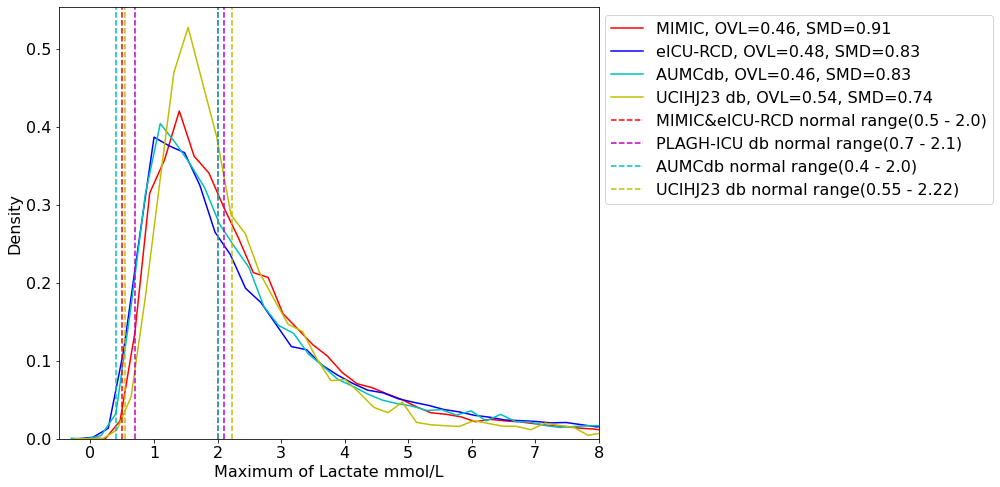

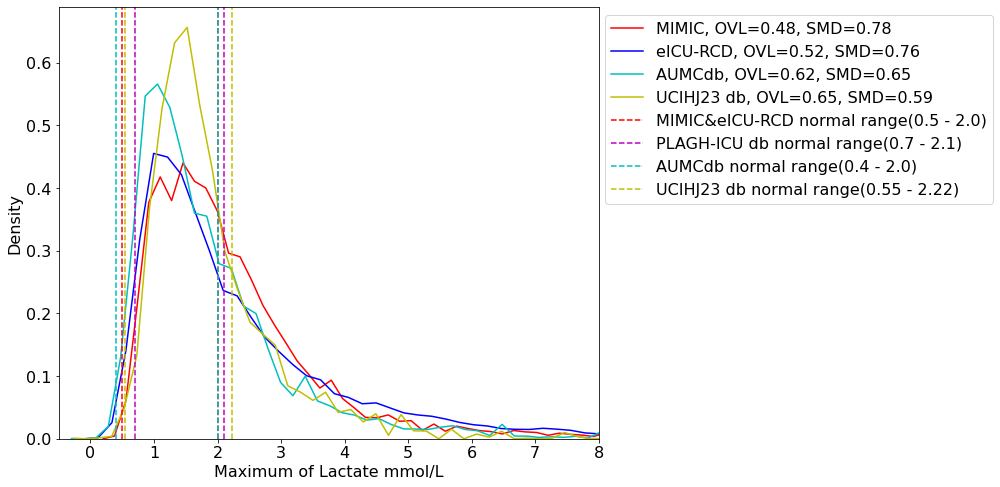

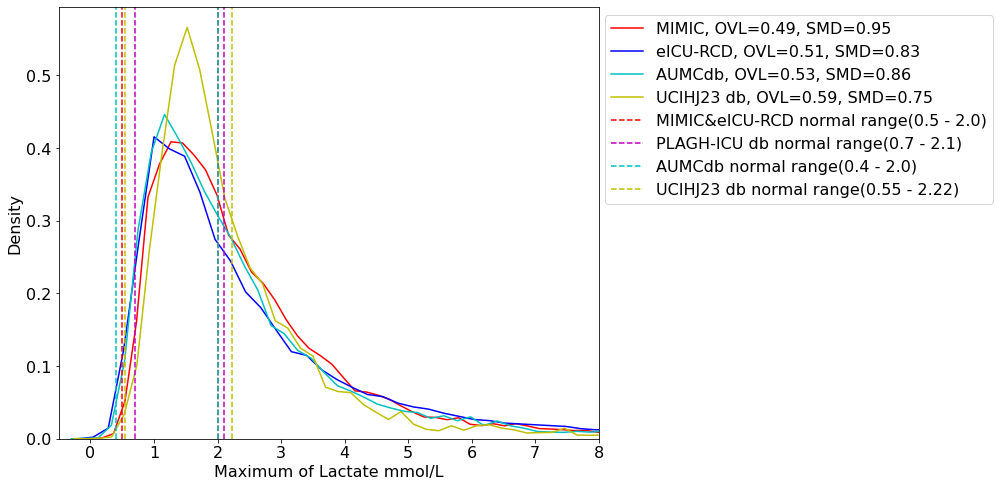

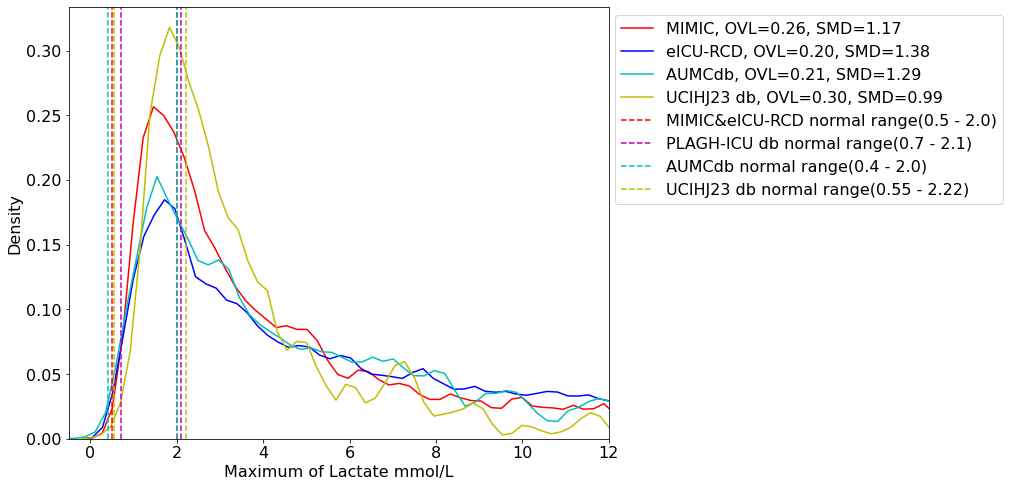

In [34]:
plot_betweendatabase('lactate_max','all',0,np.inf,0.1)
plt.xlim(-0.5,8)
plt.legend(bbox_to_anchor=(1.745, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Lactate mmol/L',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('lactate_max','lactate_max of all patients'), dpi=300)


plot_betweendatabase('lactate_max','bestoutcome',0,np.inf,0.1)
plt.xlim(-0.5,8)
plt.legend(bbox_to_anchor=(1.745, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Lactate mmol/L',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('lactate_max','lactate_max of best outcome patients'), dpi=300)


plot_betweendatabase('lactate_max',0,0,np.inf,0.1)
plt.xlim(-0.5,8)
plt.legend(bbox_to_anchor=(1.745, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Lactate mmol/L',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('lactate_max','lactate_max of survival patients'), dpi=300)


#bw in expired we set is 0.2 to smooth the curves
plot_betweendatabase('lactate_max',1,0,np.inf,0.2)
plt.xlim(-0.5,12)
plt.legend(bbox_to_anchor=(1.745, 1), fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.6, top=0.9)
plt.xlabel('Maximum of Lactate mmol/L',fontsize=16)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('lactate_max','lactate_max of expired patients'), dpi=300)

In [35]:
ovl_best_df

,SODIUM,CREATININE,HEMOGLOBIN,LACTATE
MIMIC_vs_eICU-RCD,0.95,0.87,0.81,0.90
MIMIC_vs_PLAGH-ICU db,0.85,0.70,0.68,0.99
MIMIC_vs_AUMCdb,0.87,0.95,0.96,0.85
MIMIC_vs_UCIHJ23 db,0.92,0.85,0.86,0.87
eICU-RCD_vs_MIMIC,0.95,0.87,0.81,0.90
eICU-RCD_vs_PLAGH-ICU db,0.86,0.59,0.84,0.90
eICU-RCD_vs_AUMCdb,0.87,0.86,0.78,0.87
eICU-RCD_vs_UCIHJ23 db,0.92,0.81,0.92,0.87
PLAGH-ICU db_vs_MIMIC,0.85,0.70,0.68,0.99
PLAGH-ICU db_vs_eICU-RCD,0.86,0.59,0.84,0.90


In [36]:
ovl_worst_df

,SODIUM,CREATININE,HEMOGLOBIN,LACTATE
MIMIC_vs_eICU-RCD,0.96,0.86,0.89,0.83
MIMIC_vs_PLAGH-ICU db,0.95,0.87,0.83,0.98
MIMIC_vs_AUMCdb,0.79,0.91,0.91,0.86
MIMIC_vs_UCIHJ23 db,0.91,0.95,0.88,0.89
eICU-RCD_vs_MIMIC,0.96,0.86,0.89,0.83
eICU-RCD_vs_PLAGH-ICU db,0.97,0.75,0.90,0.83
eICU-RCD_vs_AUMCdb,0.81,0.87,0.94,0.92
eICU-RCD_vs_UCIHJ23 db,0.92,0.86,0.93,0.76
PLAGH-ICU db_vs_MIMIC,0.95,0.87,0.83,0.98
PLAGH-ICU db_vs_eICU-RCD,0.97,0.75,0.90,0.83


In [37]:
smd_best_df

,SODIUM,CREATININE,HEMOGLOBIN,LACTATE
MIMIC_vs_eICU-RCD,0.03,-0.18,-0.31,-0.02
MIMIC_vs_PLAGH-ICU db,-0.33,0.40,-0.79,nan
MIMIC_vs_AUMCdb,-0.26,0.01,0.04,0.28
MIMIC_vs_UCIHJ23 db,-0.21,-0.00,-0.19,0.21
eICU-RCD_vs_MIMIC,-0.03,0.18,0.31,0.02
eICU-RCD_vs_PLAGH-ICU db,-0.33,0.44,-0.36,nan
eICU-RCD_vs_AUMCdb,-0.26,0.18,0.35,0.27
eICU-RCD_vs_UCIHJ23 db,-0.22,0.17,0.14,0.21
PLAGH-ICU db_vs_MIMIC,0.33,-0.40,0.79,nan
PLAGH-ICU db_vs_eICU-RCD,0.33,-0.44,0.36,nan


In [38]:
smd_worst_df

,SODIUM,CREATININE,HEMOGLOBIN,LACTATE
MIMIC_vs_eICU-RCD,-0.03,-0.23,0.03,-0.33
MIMIC_vs_PLAGH-ICU db,-0.03,0.07,-0.21,nan
MIMIC_vs_AUMCdb,-0.47,0.05,0.11,-0.25
MIMIC_vs_UCIHJ23 db,-0.17,0.02,-0.14,0.11
eICU-RCD_vs_MIMIC,0.03,0.23,-0.03,0.33
eICU-RCD_vs_PLAGH-ICU db,-0.01,0.29,-0.23,nan
eICU-RCD_vs_AUMCdb,-0.42,0.27,0.08,0.09
eICU-RCD_vs_UCIHJ23 db,-0.13,0.24,-0.15,0.40
PLAGH-ICU db_vs_MIMIC,0.03,-0.07,0.21,nan
PLAGH-ICU db_vs_eICU-RCD,0.01,-0.29,0.23,nan


In [39]:
ovl_worst_df.to_csv('../report/ovl_worst_df.csv',index=True)
ovl_best_df.to_csv('../report/ovl_best_df.csv',index=True)

In [40]:
smd_worst_df.to_csv('../report/smd_worst_df.csv',index=True)
smd_best_df.to_csv('../report/smd_best_df.csv',index=True)

# boxplots

dropped in the end

In [22]:
lab_test_df=pd.DataFrame()
temp_df=data_mimic.loc[(data_mimic['outcome_group']==1) | (data_mimic['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='MIMIC'
lab_test_df=lab_test_df.append(temp_df)
temp_df=data_eicu.loc[(data_eicu['outcome_group']==1) | (data_eicu['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='e-ICU'
lab_test_df=lab_test_df.append(temp_df)
temp_df=data_plagh.loc[(data_plagh['outcome_group']==1) | (data_plagh['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='PLAGH'
lab_test_df=lab_test_df.append(temp_df)
temp_df=data_aumc.loc[(data_aumc['outcome_group']==1) | (data_aumc['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='AUMC'
lab_test_df=lab_test_df.append(temp_df)
temp_df=data_HJ23.loc[(data_HJ23['outcome_group']==1) | (data_HJ23['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='HJ23'
lab_test_df=lab_test_df.append(temp_df)
lab_test_df.reset_index(drop=True,inplace=True)

In [23]:
lab_test_df['outcome_group'].replace(1,'Best outcome, LOS < 1st quantile', inplace=True)
lab_test_df['outcome_group'].replace(5,'Worst outcome, expired patients', inplace=True)
lab_test_df.sort_values(by=['outcome_group'],inplace=True)

## sodium_max

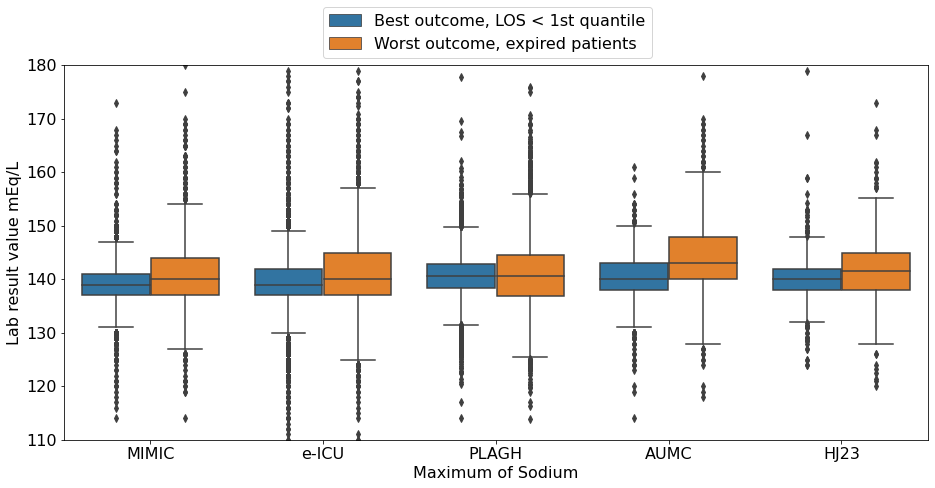

In [24]:
fig = plt.figure(figsize = (15,8))

sns.boxplot(x="database_label", y="sodium_max", hue="outcome_group",order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
plt.xlabel('Maximum of Sodium',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc=(0.3, 1.02),fontsize=16)
plt.ylabel('Lab result value mEq/L',fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(110,180)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.8)
plt.savefig('../figures/best vs worst/sodium_max_box_plot.png', dpi=300)

## creatinine_max

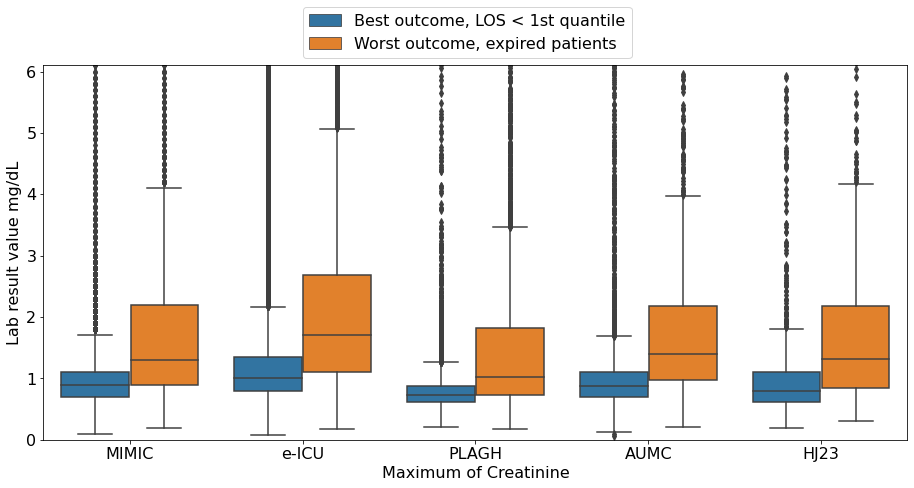

In [25]:
fig = plt.figure(figsize = (15,8))


lab_test_df.loc[lab_test_df['creatinine_max']>8,'creatinine_max']=np.nan

sns.boxplot(x="database_label", y="creatinine_max", hue="outcome_group", order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
plt.xlabel('Maximum of Creatinine',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc=(0.3, 1.02),fontsize=16)
plt.ylabel('Lab result value mg/dL',fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,6.1)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.8)
plt.savefig('../figures/best vs worst/creatinine_max_box_plot.png', dpi=300)

## lactate_max

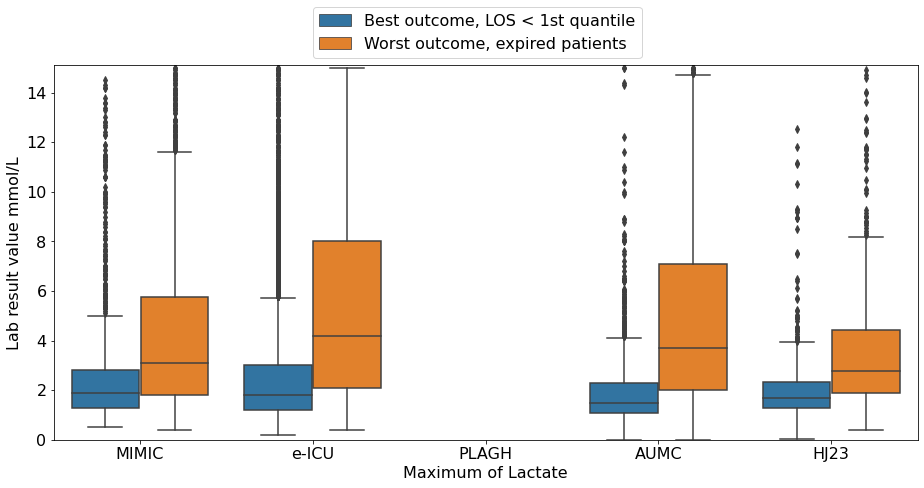

In [26]:
fig = plt.figure(figsize = (15,8))

lab_test_df.loc[lab_test_df['lactate_max']>15,'lactate_max']=np.nan

sns.boxplot(x="database_label", y="lactate_max", hue="outcome_group",order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
plt.xlabel('Maximum of Lactate',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc=(0.3, 1.02),fontsize=16)
plt.ylabel('Lab result value mmol/L',fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,15.1)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.8)
plt.savefig('../figures/best vs worst/lactate_max_box_plot.png', dpi=300)

## hemoglobin_min

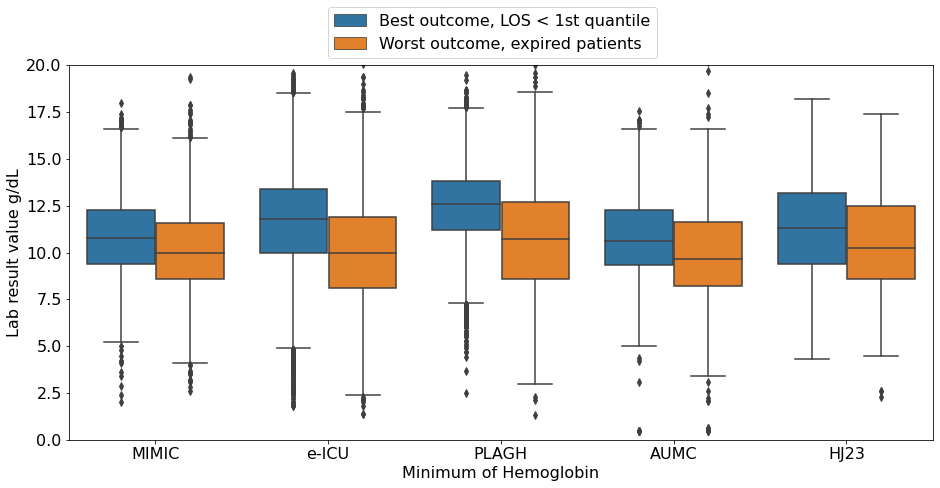

In [27]:
fig = plt.figure(figsize = (15,8))

sns.boxplot(x="database_label", y="hemoglobin_min", hue="outcome_group",order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
plt.xlabel('Minimum of Hemoglobin',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc=(0.3, 1.02),fontsize=16)
plt.ylabel('Lab result value g/dL',fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,20)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.8)
plt.savefig('../figures/best vs worst/hemoglobin_min_box_plot.png', dpi=300)

# suggest reference ranges

dropped in the end

In [28]:
best_df=lab_test_df.loc[lab_test_df['outcome_group']=='Best outcome, LOS < 1st quantile',:]
worst_df=lab_test_df.loc[lab_test_df['outcome_group']=='Worst outcome, expired patients',:]
print(best_df['hemoglobin_min'].quantile(0.025))
print(best_df['hemoglobin_min'].quantile(0.975))
print(worst_df['hemoglobin_min'].quantile(0.025))
print(worst_df['hemoglobin_min'].quantile(0.975))

7.0
15.8
5.4
15.5


In [29]:
print(best_df.shape[0])
print(worst_df.shape[0])

62026
16855


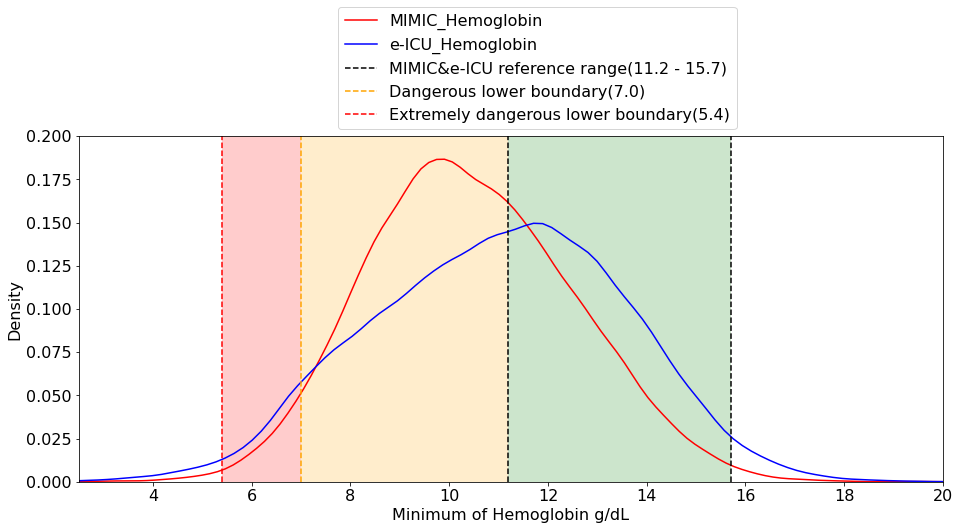

In [30]:
fig=plt.figure(figsize=(15,8))
sns.kdeplot(data_mimic['hemoglobin_min'].dropna(),color='r',label='MIMIC_Hemoglobin')
sns.kdeplot(data_eicu['hemoglobin_min'].dropna(),color='b',label='e-ICU_Hemoglobin')

plt.axvline(lab_ranges_us[('hemoglobin').upper()][0],color='k',linestyle='--', 
            label='MIMIC&e-ICU reference range({} - {})'.format(lab_ranges_us[('hemoglobin').upper()][0], lab_ranges_us[('hemoglobin').upper()][1]))
plt.axvline(lab_ranges_us[('hemoglobin').upper()][1],color='k',linestyle='--')
plt.fill_between([lab_ranges_us[('hemoglobin').upper()][0],lab_ranges_us[('hemoglobin').upper()][1]],
                 [0],
                 [1],
                 facecolor='green',alpha=0.2)

plt.axvline(best_df['hemoglobin_min'].quantile(0.025),color='orange',linestyle='--',
            label='Dangerous lower boundary({})'.format(best_df['hemoglobin_min'].quantile(0.025)))
plt.fill_between([best_df['hemoglobin_min'].quantile(0.025),lab_ranges_us[('hemoglobin').upper()][0]],
                 [0],
                 [1],
                 facecolor='orange',alpha=0.2)

plt.axvline(worst_df['hemoglobin_min'].quantile(0.025),color='r',linestyle='--',
            label='Extremely dangerous lower boundary({})'.format(worst_df['hemoglobin_min'].quantile(0.025)))
plt.fill_between([worst_df['hemoglobin_min'].quantile(0.025),best_df['hemoglobin_min'].quantile(0.025)],
                 [0],
                 [1],
                 facecolor='r',alpha=0.2)

plt.legend(loc=(0.3, 1.02),fontsize=16)
plt.xlabel('Minimum of Hemoglobin g/dL',fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xlim(2.5,20)
plt.ylim(0,0.2)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.75)
plt.savefig('../figures/suggest reference ranges/hemoglobin_min.png', dpi=300)

In [31]:
print(best_df['lactate_max'].quantile(0.975))
print(worst_df['lactate_max'].quantile(0.975))

8.804999999999927
13.9


In [32]:
print(worst_df['lactate_max'].notnull().sum())

8782


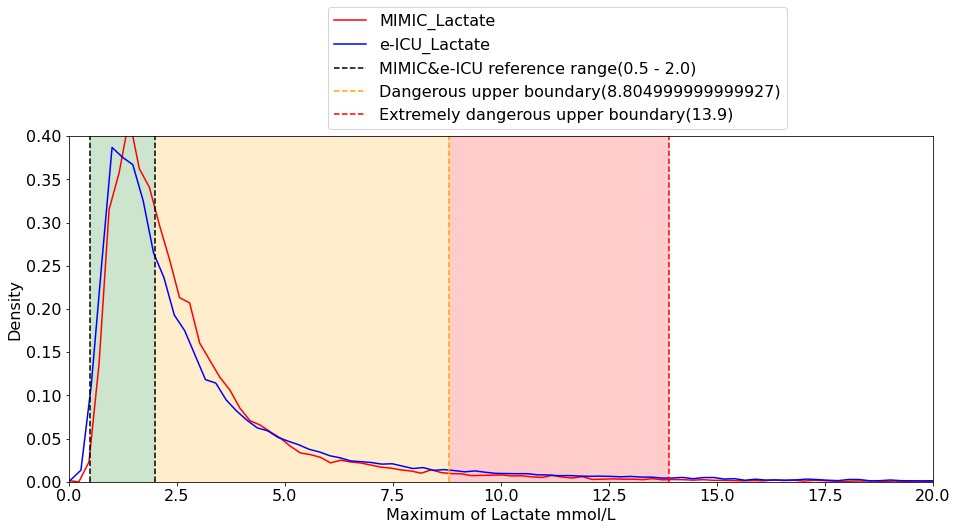

In [33]:
fig=plt.figure(figsize=(15,8))
sns.kdeplot(data_mimic['lactate_max'].dropna(),color='r',label='MIMIC_Lactate',bw=0.1)
sns.kdeplot(data_eicu['lactate_max'].dropna(),color='b',label='e-ICU_Lactate',bw=0.1)

plt.axvline(lab_ranges_us[('lactate').upper()][0],color='k',linestyle='--', 
            label='MIMIC&e-ICU reference range({} - {})'.format(lab_ranges_us[('lactate').upper()][0], lab_ranges_us[('lactate').upper()][1]))
plt.axvline(lab_ranges_us[('lactate').upper()][1],color='k',linestyle='--')
plt.fill_between([lab_ranges_us[('lactate').upper()][0],lab_ranges_us[('lactate').upper()][1]],
                 [0],
                 [1],
                 facecolor='green',alpha=0.2)

plt.axvline(best_df['lactate_max'].quantile(0.975),color='orange',linestyle='--',
            label='Dangerous upper boundary({})'.format(best_df['lactate_max'].quantile(0.975)))
plt.fill_between([best_df['lactate_max'].quantile(0.975),lab_ranges_us[('lactate').upper()][1]],
                 [0],
                 [1],
                 facecolor='orange',alpha=0.2)

plt.axvline(worst_df['lactate_max'].quantile(0.975),color='r',linestyle='--',
            label='Extremely dangerous upper boundary({})'.format(worst_df['lactate_max'].quantile(0.975)))
plt.fill_between([worst_df['lactate_max'].quantile(0.975),best_df['lactate_max'].quantile(0.975)],
                 [0],
                 [1],
                 facecolor='r',alpha=0.2)

plt.legend(loc=(0.3, 1.02),fontsize=16)
plt.xlabel('Maximum of Lactate mmol/L',fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xlim(0,20)
plt.ylim(0,0.4)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.75)
plt.savefig('../figures/suggest reference ranges/lactate_max.png', dpi=300)

In [34]:
print(best_df['creatinine_max'].quantile(0.975))
print(worst_df['creatinine_max'].quantile(0.975))

3.89
5.833432126696829


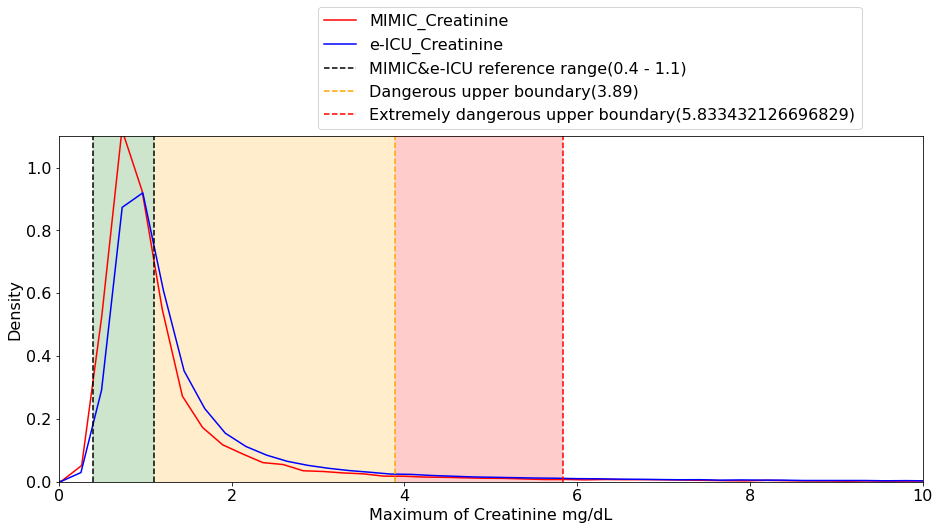

In [35]:
fig=plt.figure(figsize=(15,8))
sns.kdeplot(data_mimic['creatinine_max'].dropna(),color='r',label='MIMIC_Creatinine',bw=0.1)
sns.kdeplot(data_eicu['creatinine_max'].dropna(),color='b',label='e-ICU_Creatinine',bw=0.1)

plt.axvline(lab_ranges_us[('creatinine').upper()][0],color='k',linestyle='--', 
            label='MIMIC&e-ICU reference range({} - {})'.format(lab_ranges_us[('creatinine').upper()][0], lab_ranges_us[('creatinine').upper()][1]))
plt.axvline(lab_ranges_us[('creatinine').upper()][1],color='k',linestyle='--')
plt.fill_between([lab_ranges_us[('creatinine').upper()][0],lab_ranges_us[('creatinine').upper()][1]],
                 [0],
                 [1.2],
                 facecolor='green',alpha=0.2)

plt.axvline(best_df['creatinine_max'].quantile(0.975),color='orange',linestyle='--',
            label='Dangerous upper boundary({})'.format(best_df['creatinine_max'].quantile(0.975)))
plt.fill_between([best_df['creatinine_max'].quantile(0.975),lab_ranges_us[('creatinine').upper()][1]],
                 [0],
                 [1.2],
                 facecolor='orange',alpha=0.2)

plt.axvline(worst_df['creatinine_max'].quantile(0.975),color='r',linestyle='--',
            label='Extremely dangerous upper boundary({})'.format(worst_df['creatinine_max'].quantile(0.975)))
plt.fill_between([worst_df['creatinine_max'].quantile(0.975),best_df['creatinine_max'].quantile(0.975)],
                 [0],
                 [1.2],
                 facecolor='r',alpha=0.2)

plt.legend(loc=(0.3, 1.02),fontsize=16)
plt.xlabel('Maximum of Creatinine mg/dL',fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xlim(0,10)
plt.ylim(0,1.1)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.75)
plt.savefig('../figures/suggest reference ranges/creatinine_max.png', dpi=300)

In [36]:
print(best_df['sodium_max'].quantile(0.025))
print(worst_df['sodium_max'].quantile(0.025))
print(best_df['sodium_max'].quantile(0.975))
print(worst_df['sodium_max'].quantile(0.975))

131.0
129.0
147.0
157.0


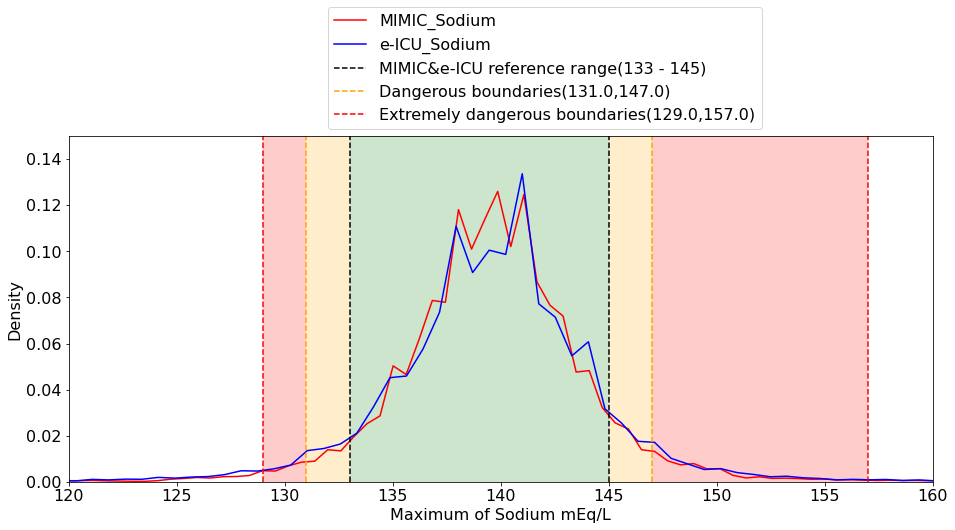

In [37]:
fig=plt.figure(figsize=(15,8))
sns.kdeplot(data_mimic['sodium_max'].dropna(),color='r',label='MIMIC_Sodium')
sns.kdeplot(data_eicu['sodium_max'].dropna(),color='b',label='e-ICU_Sodium')

plt.axvline(lab_ranges_us[('sodium').upper()][0],color='k',linestyle='--', 
            label='MIMIC&e-ICU reference range({} - {})'.format(lab_ranges_us[('sodium').upper()][0], lab_ranges_us[('sodium').upper()][1]))
plt.axvline(lab_ranges_us[('sodium').upper()][1],color='k',linestyle='--')
plt.fill_between([lab_ranges_us[('sodium').upper()][0],lab_ranges_us[('sodium').upper()][1]],
                 [0],
                 [1.2],
                 facecolor='green',alpha=0.2)

plt.axvline(best_df['sodium_max'].quantile(0.975),color='orange',linestyle='--',
            label='Dangerous boundaries({},{})'.format(best_df['sodium_max'].quantile(0.025),best_df['sodium_max'].quantile(0.975)))
plt.fill_between([best_df['sodium_max'].quantile(0.975),lab_ranges_us[('sodium').upper()][1]],
                 [0],
                 [1.2],
                 facecolor='orange',alpha=0.2)
plt.axvline(best_df['sodium_max'].quantile(0.025),color='orange',linestyle='--')
plt.fill_between([best_df['sodium_max'].quantile(0.025),lab_ranges_us[('sodium').upper()][0]],
                 [0],
                 [1.2],
                 facecolor='orange',alpha=0.2)

plt.axvline(worst_df['sodium_max'].quantile(0.975),color='r',linestyle='--',
            label='Extremely dangerous boundaries({},{})'.format(worst_df['sodium_max'].quantile(0.025),worst_df['sodium_max'].quantile(0.975)))
plt.fill_between([worst_df['sodium_max'].quantile(0.975),best_df['sodium_max'].quantile(0.975)],
                 [0],
                 [1.2],
                 facecolor='r',alpha=0.2)
plt.axvline(worst_df['sodium_max'].quantile(0.025),color='r',linestyle='--')
plt.fill_between([worst_df['sodium_max'].quantile(0.025),best_df['sodium_max'].quantile(0.025)],
                 [0],
                 [1.2],
                 facecolor='r',alpha=0.2)

plt.legend(loc=(0.3, 1.02),fontsize=16)
plt.xlabel('Maximum of Sodium mEq/L',fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xlim(120,160)
plt.ylim(0,0.15)
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.75)
plt.savefig('../figures/suggest reference ranges/sodium_max.png', dpi=300)

# best vs worst in every database

In [42]:
dict_database=dict({'MIMIC':[data_mimic,lab_ranges_us],
                   'eICU-RCD':[data_eicu,lab_ranges_us],
                   'PLAGH-ICU db':[data_plagh,lab_ranges_cn],
                   'AUMCdb':[data_aumc,lab_ranges_netherlands],
                   'UCIHJ23 db':[data_HJ23,lab_ranges_hj23] })

In [43]:
bestvsworst_df=pd.DataFrame()
newranges_df=pd.DataFrame()

In [44]:
integration_ranges = {'CREATININE': [0, np.inf],
                      'HEMOGLOBIN': [2.5,np.inf],
                      'LACTATE': [0,np.inf],
                      'SODIUM': [100,180],
                      }

x_ranges={'CREATININE': [-0.5, 10],
          'HEMOGLOBIN': [2.5,20],
          'LACTATE': [-0.5,18],
          'SODIUM': [120,160],
          }

units={'CREATININE': 'mg/dL',
      'HEMOGLOBIN': 'g/dL',
      'LACTATE': 'mmol/L',
      'SODIUM': 'mEq/L',
      }

lab_bw={'CREATININE': 0.12,
      'HEMOGLOBIN': 0.6,
      'LACTATE': 0.15,
      'SODIUM': 0.8,
      }

rangeline_position={'CREATININE': [0.1, 0.2],
                    'HEMOGLOBIN': [0.015, 0.03],
                    'LACTATE': [0.04,0.08],
                    'SODIUM': [0.012,0.024],
                    }

Now processing:MIMIC
    creatinine_max in MIMIC
    hemoglobin_min in MIMIC
    lactate_max in MIMIC
    sodium_max in MIMIC
Now processing:eICU-RCD
    creatinine_max in eICU-RCD
    hemoglobin_min in eICU-RCD
    lactate_max in eICU-RCD
    sodium_max in eICU-RCD
Now processing:PLAGH-ICU db
    creatinine_max in PLAGH-ICU db
    hemoglobin_min in PLAGH-ICU db
    sodium_max in PLAGH-ICU db
Now processing:AUMCdb
    creatinine_max in AUMCdb
    hemoglobin_min in AUMCdb
    lactate_max in AUMCdb
    sodium_max in AUMCdb
Now processing:UCIHJ23 db
    creatinine_max in UCIHJ23 db
    hemoglobin_min in UCIHJ23 db
    lactate_max in UCIHJ23 db
    sodium_max in UCIHJ23 db


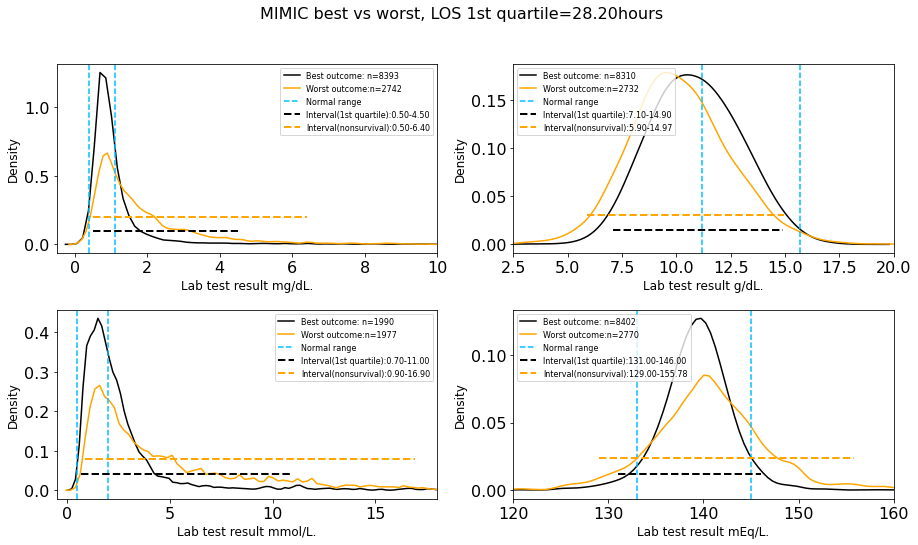

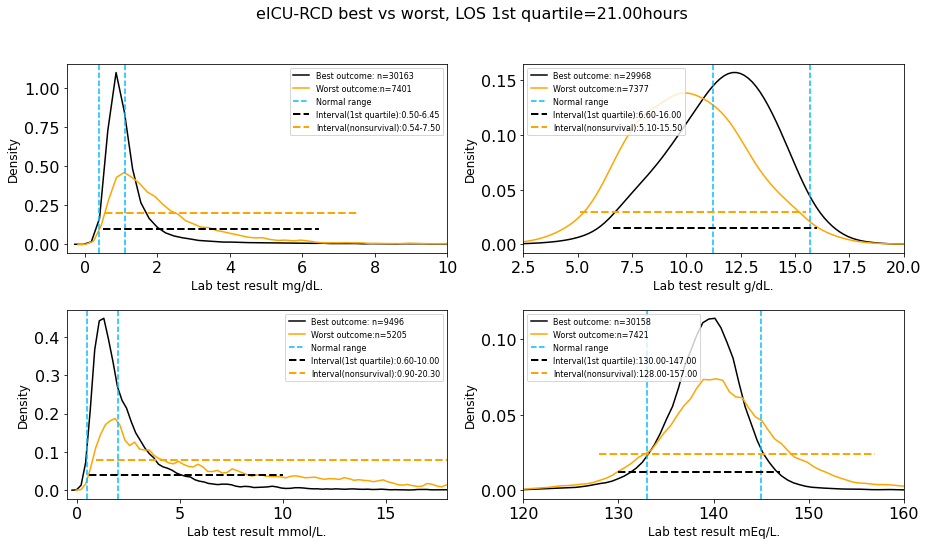

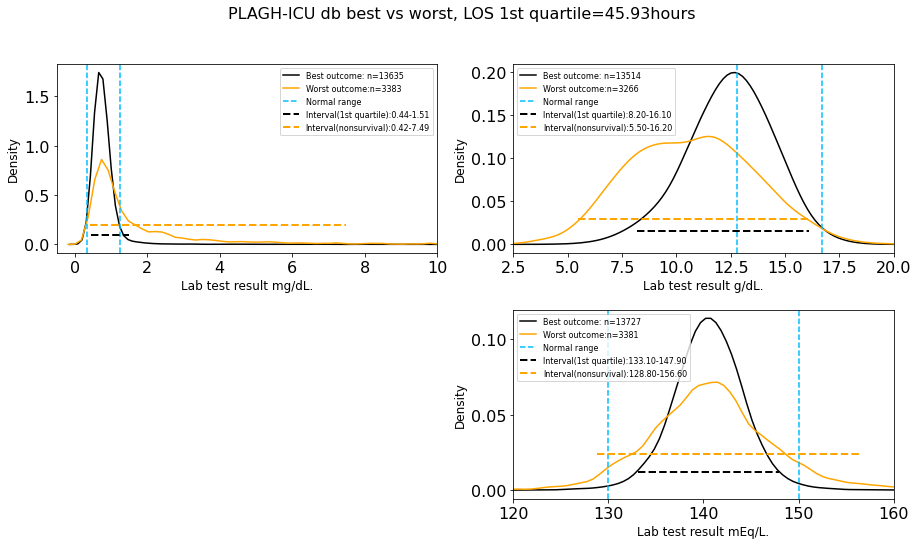

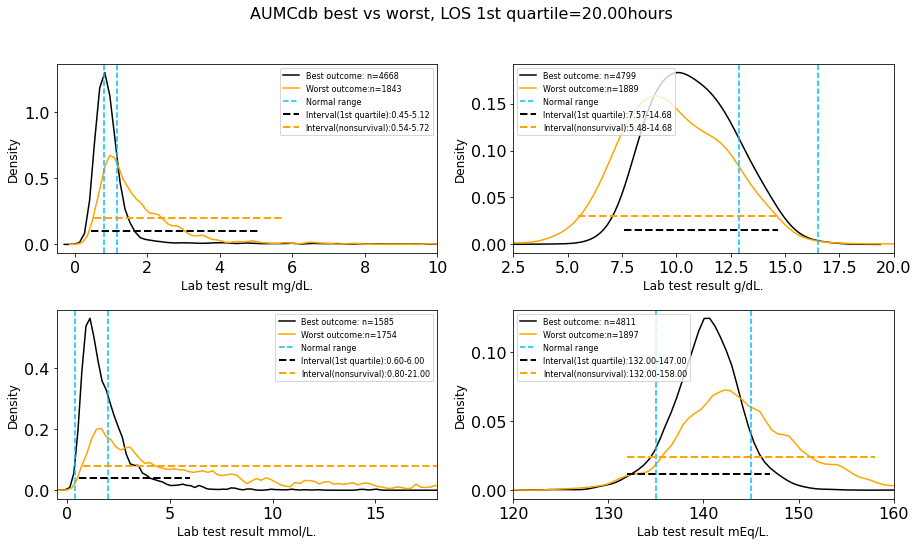

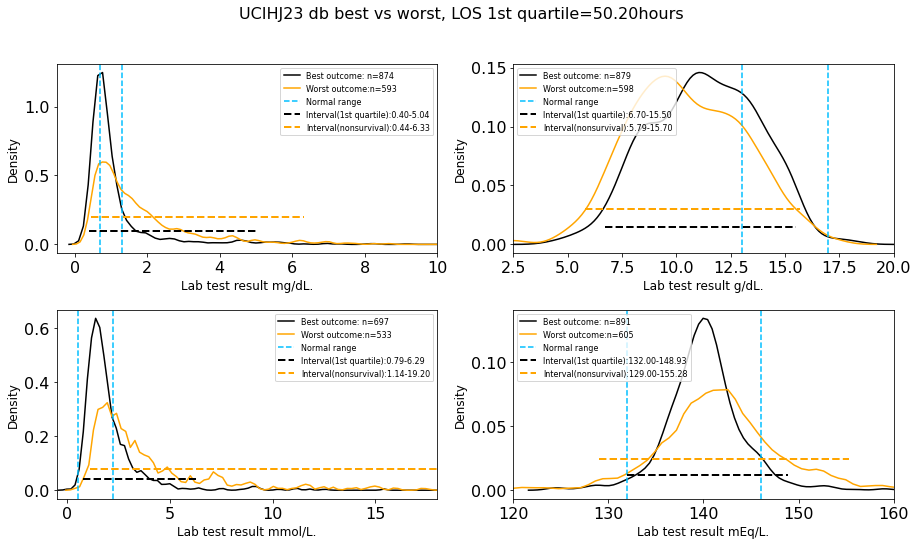

In [46]:
for database_name in database_names:
    print('Now processing:{}'.format(database_name))
    q1=dict_database[database_name][0].loc[dict_database[database_name][0]['icu_expire_flag']==0,:]['icu_los_hours'].describe()['25%']
    best_df=dict_database[database_name][0].loc[dict_database[database_name][0]['outcome_group']==1, :]
    worst_df=dict_database[database_name][0].loc[dict_database[database_name][0]['outcome_group']==5, :]
    fig_num=1
    fig=plt.figure(figsize=(15,8))
    for lab in lab_names:
        if (lab == 'lactate_max') & (database_name == 'PLAGH-ICU db'):
            fig_num += 1
            continue
            
        print('    {} in {}'.format(lab,database_name ))
        range_name = lab.split('_')[0].upper()
        
        best_kde=gaussian_kde(best_df[lab].dropna())
        worst_kde=gaussian_kde(worst_df[lab].dropna())
        
        ovl='%.2f'%max(get_OVL(best_kde, worst_kde, integration_ranges[range_name][0], integration_ranges[range_name][1]))
        smd='%.2f'%cohen_d(best_df[lab].dropna(),worst_df[lab].dropna())
        
        best_lower = best_df[lab].dropna().quantile(0.025)
        best_upper = best_df[lab].dropna().quantile(0.975)
        worst_lower = worst_df[lab].dropna().quantile(0.025)
        worst_upper = worst_df[lab].dropna().quantile(0.975)
        
        bestvsworst_df.loc[database_name, range_name + '_OVL'] = ovl
        bestvsworst_df.loc[database_name, range_name + '_SMD'] = smd
        
        newranges_df.loc[database_name, range_name + '_best'] = '({} - {})'.format('%.2f'%best_lower, '%.2f'%best_upper)
        newranges_df.loc[database_name, range_name + '_worst'] = '({} - {})'.format('%.2f'%worst_lower, '%.2f'%worst_upper)
        
        
        plt.subplot(2,2,fig_num)
        sns.kdeplot(best_df[lab].dropna(),color='k',
                label='Best outcome: n={}'.format(best_df[lab].notnull().sum() ),bw=lab_bw[range_name])
        sns.kdeplot(worst_df[lab].dropna(),color='orange',
                label='Worst outcome:n={}'.format(worst_df[lab].notnull().sum() ),bw=lab_bw[range_name])
        
        plt.axvline(dict_database[database_name][1][range_name][0],color='deepskyblue',linestyle='--', label='Normal range')
        plt.axvline(dict_database[database_name][1][range_name][1],color='deepskyblue',linestyle='--')
        
        #print(best_kde.pdf(x).max())
        
        plt.plot([best_lower,best_upper],[rangeline_position[range_name][0], rangeline_position[range_name][0]],
                 'k--',linewidth=2,label='Interval(1st quartile):{}-{}'.format('%.2f'%best_lower, '%.2f'%best_upper))
        plt.plot([worst_lower,worst_upper],[rangeline_position[range_name][1], rangeline_position[range_name][1]],
                 'orange',linestyle='--',linewidth=2,label='Interval(nonsurvival):{}-{}'.format('%.2f'%worst_lower, '%.2f'%worst_upper))
        
        
        plt.xlim(x_ranges[range_name][0],x_ranges[range_name][1])
        #plt.title(range_name,fontsize=12)
        plt.ylabel('Density',fontsize=12)
        plt.xlabel('Lab test result {}.'.format(units[range_name]),fontsize=12)
        
        if (fig_num == 2) | (fig_num == 4) :
            plt.legend(fontsize=8,loc='upper left')
        else:
            plt.legend(fontsize=8,loc='upper right')
        
        fig_num += 1
    
    plt.subplots_adjust(wspace=0.2,hspace=0.3)
    #plt.tight_layout()
    plt.suptitle('{} best vs worst, LOS 1st quartile={}hours'.format(database_name,'%.2f'%q1),fontsize=16)    
    #plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=9)
    plt.savefig('../figures/best vs worst/{} best vs worst, LOS 1st quartile={}.png'.format(database_name,'%.2f'%q1), dpi=300)

In [47]:
bestvsworst_df

,CREATININE_OVL,CREATININE_SMD,HEMOGLOBIN_OVL,HEMOGLOBIN_SMD,LACTATE_OVL,LACTATE_SMD,SODIUM_OVL,SODIUM_SMD
MIMIC,0.65,-0.53,0.85,0.35,0.65,-0.65,0.76,-0.31
eICU-RCD,0.62,-0.48,0.74,0.61,0.57,-1.03,0.77,-0.35
PLAGH-ICU db,0.48,-0.92,0.67,0.80,NaN,NaN,0.75,-0.09
AUMCdb,0.61,-0.48,0.81,0.42,0.47,-1.01,0.67,-0.74
UCIHJ23 db,0.67,-0.46,0.86,0.32,0.57,-0.73,0.75,-0.31


In [48]:
newranges_df

,CREATININE_best,CREATININE_worst,HEMOGLOBIN_best,HEMOGLOBIN_worst,LACTATE_best,LACTATE_worst,SODIUM_best,SODIUM_worst
MIMIC,(0.50 - 4.50),(0.50 - 6.40),(7.10 - 14.90),(5.90 - 14.97),(0.70 - 11.00),(0.90 - 16.90),(131.00 - 146.00),(129.00 - 155.78)
eICU-RCD,(0.50 - 6.45),(0.54 - 7.50),(6.60 - 16.00),(5.10 - 15.50),(0.60 - 10.00),(0.90 - 20.30),(130.00 - 147.00),(128.00 - 157.00)
PLAGH-ICU db,(0.44 - 1.51),(0.42 - 7.49),(8.20 - 16.10),(5.50 - 16.20),NaN,NaN,(133.10 - 147.90),(128.80 - 156.60)
AUMCdb,(0.45 - 5.12),(0.54 - 5.72),(7.57 - 14.68),(5.48 - 14.68),(0.60 - 6.00),(0.80 - 21.00),(132.00 - 147.00),(132.00 - 158.00)
UCIHJ23 db,(0.40 - 5.04),(0.44 - 6.33),(6.70 - 15.50),(5.79 - 15.70),(0.79 - 6.29),(1.14 - 19.20),(132.00 - 148.93),(129.00 - 155.28)


In [44]:
bestvsworst_df.to_csv('../report/bestvsworst_df.csv',index=True)
newranges_df.to_csv('../report/newranges_df.csv',index=True)